<a href="https://colab.research.google.com/github/manoel-nto/Logistic_Facilities_Distribution_Analysis/blob/main/2_distance_metrics_and_spatial_association_indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 Métricas de distância e medidas de associação espacial

As métricas de distância utilizadas foram o centro médio e Standard Deviational Ellipse (SDE). Para (auto)correlação espacial, foram utilizados os índices de Moran (Moran's I) univariados e bivariados.

Assim, foi possível identificar onde as empresas do setor logístico estão concentradas, a proximidade em relação às rodovias e a relação entre a localização das empresas e essa infraestrura de transporte.

Por fim, foram identificadas as zonas de localização das empresas, isto é, em quais zonas urbanas ou rurais elas se encontram. O zoneamento pode ajudar a explicar a concentração das empresas ao sudoeste do DF (seções 2.3.2 e 2.3.3).

## 2.1 Preparando ambiente

### 2.1.1 Montar Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 2.1.2 Baixar pacotes para análise espacial

In [ ]:
!pip install pointpats
!pip install libpysal
!pip install splot
!pip install esda
!pip install contextily
!pip install shapely

### 2.1.3 Imports

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
from seaborn import color_palette
import geopandas as gpd
import contextily as ctx
import shapely.affinity
from shapely.geometry.point import Point

import pointpats as pp
from splot.libpysal import plot_spatial_weights
from libpysal.weights.contiguity import Queen
from libpysal.weights import lag_spatial
from esda.moran import Moran
from splot.esda import plot_moran
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv

from logging import getLogger, CRITICAL
getLogger('matplotlib.font_manager').setLevel(level=CRITICAL)
%matplotlib inline

In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/spatial_distribution_logistic_facilities/'

## 2.2 Dados

In [5]:
directory_files = os.listdir(
    '/content/drive/MyDrive/Colab Notebooks/spatial_distribution_logistic_facilities/data'
)

In [6]:
# Arquivos utilizados
directory_files[-12:]

['11_regioes_administrativas.zip',
 '12_zoneamento_distrito_federal.zip',
 '13_rodovias_estaduais.zip',
 '14_rodovias_federais.zip',
 '17_cnaes_df.csv',
 '16_log_companies_df.csv',
 '15_companies_df.csv',
 '18_addresses_gdf.gpkg',
 '20_df_highways_ras.gpkg',
 '19_companies_ol_gdf.gpkg',
 '21_df_federal_highways_ras.gpkg',
 '22_final_ras.gpkg']

In [7]:
# Lendo arquivos
d = {}
for i in directory_files[-12:]:
    d[i[3:i.find('.')]] = gpd.read_file(
        f'data/{i}',
        enconding='utf-8'
    )

In [8]:
list(d.keys())

['regioes_administrativas',
 'zoneamento_distrito_federal',
 'rodovias_estaduais',
 'rodovias_federais',
 'cnaes_df',
 'log_companies_df',
 'companies_df',
 'addresses_gdf',
 'df_highways_ras',
 'companies_ol_gdf',
 'df_federal_highways_ras',
 'final_ras']

## 2.3 Mapeamento das instalações logísticas no Distrito Federal



### 2.3.1 Localização das empresas por RA

Foram identificadas regiões maior e menor ocorrência das empresas do setor logístico localizadas no DF.

In [9]:
# Coordenadas
x_coord = np.array(d['companies_ol_gdf']['geometry'].x)
y_coord = np.array(d['companies_ol_gdf']['geometry'].y)

In [10]:
# Empresas
f_companies = d['final_ras'][['ra_cira', 'ra_nome','cnpj', 'geometry']].sort_values(by='cnpj', ascending=False, ignore_index=True)

In [11]:
# 5 RA com maior ocorrência de empresas
f_companies.head(5)

ra_cira           ra_nome  cnpj  \
0        9         CEILÂNDIA  1391   
1       12         SAMAMBAIA   905   
2        3        TAGUATINGA   854   
3       15  RECANTO DAS EMAS   499   
4       13       SANTA MARIA   471   

                                            geometry  
0  POLYGON ((159451.527 8256079.011, 159529.189 8...  
1  POLYGON ((170603.478 8245667.452, 170634.353 8...  
2  POLYGON ((173604.783 8255372.856, 173636.964 8...  
3  POLYGON ((151896.158 8233281.055, 151896.159 8...  
4  POLYGON ((190476.860 8232091.940, 190489.180 8...

In [12]:
# 5 RA com menor ocorrência de empresas
f_companies.tail(5)

ra_cira      ra_nome  cnpj  \
30       16     LAGO SUL    40   
31       11     CRUZEIRO    33   
32       18   LAGO NORTE    31   
33       35  AGUA QUENTE    31   
34       23       VARJÃO    24   

                                             geometry  
30  POLYGON ((199614.244 8252004.645, 199620.726 8...  
31  POLYGON ((185218.919 8250376.730, 185060.128 8...  
32  POLYGON ((191773.599 8262830.863, 191784.192 8...  
33  POLYGON ((153213.898 8236204.583, 153217.306 8...  
34  POLYGON ((192598.313 8260342.548, 192433.544 8...

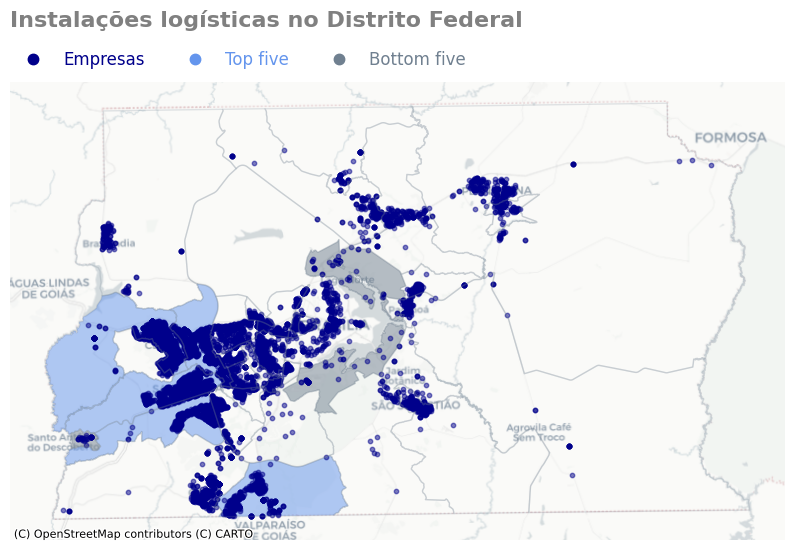

In [13]:
clrs = ['darkblue', 'cornflowerblue', 'slategrey']

# Configurar figura e eixo
fig, ax = plt.subplots(1, figsize=(10, 8))

# Limites das RA
d['regioes_administrativas'].boundary.plot(
    ax=ax,
    linewidth=1,
    alpha=0.2,
    color='slategrey'
)

# Maior ocorrência de empresas
f_companies.head(5).plot(
    ax=ax,
    linewidth=1,
    alpha=0.5,
    color=clrs[1],
)

# Menor ocorrência de empresas
f_companies.tail(5).plot(
    ax=ax,
    linewidth=1,
    alpha=0.5,
    color=clrs[2],
)

# Empresas (pontos)
ax.scatter(
    x=x_coord,
    y=y_coord,
    c=clrs[0],
    s=10,
    alpha=0.5,
    zorder=1
)

# Mapa base
ctx.add_basemap(
    ax,
    crs=d['final_ras'].crs.to_string(),
    source=ctx.providers.CartoDB.Positron)

# Title
ax.set_title(
    'Instalações logísticas no Distrito Federal',
    loc='left',
    pad=40,
    fontname='Arial',
    fontsize=16,
    color='grey',
    weight='bold')

# Legendas
custom_points = [Line2D([0], [0], marker='o', linestyle='none', markersize=5, color=color) for color in clrs]
leg_points = ax.legend(
    custom_points,
    ['Empresas', 'Top five', 'Bottom five'],
    ncol=3,
    loc='center left',
    bbox_to_anchor=[0, 1.05],
    borderaxespad=0,
    markerscale=1.5,
    fontsize=12,
    frameon=False,
    labelcolor=clrs
)

# Retirar eixos
ax.set_axis_off()

# Mostrar
plt.show()

### 2.3.2 *Mean Center* e *Standard Deviational Ellipse (SDE)*

O SDE é uma medida na qual uma elipse é desenhada a partir do centro médio ou outra medida de centralidade, sumarizando, assim, tanto a dispersão quanto a concentração de um conjunto de objetos (Yuill, 1971).

A elipse foi traçada ao redor do centro médio dos pontos que identificam as empresas (coordenadas), permitindo analisar a dispersão/concentração dos pontos nas diferentes regiões administrativas do DF.

Mean Center (Centro Médio): <br>
$$
M = \left(\sum_i \frac{x_i}{n}, \sum_i \frac{y_i}{n} \right)= (\bar{x}, \bar{y})
$$

In [14]:
# Mean Center (Centro médio)
coordinates = np.array(list(zip(x_coord,  y_coord)))
mean_center = pp.centrography.mean_center(
    points=coordinates
)

# Standard Deviational Ellipse (SDE) parameters
major, minor, rotation = pp.centrography.ellipse(
    points=coordinates
)

In [15]:
# Criando elipse
# 1º elem = coordenadas (x,y) do centro
# 2º elem = os dois valores do semi-eixo (ao longo de x, ao longo de y)
# 3º elem = ângulo em graus entre o eixo x da base cartesiana e o semi-eixo correspondente
ellipse = (mean_center,(major, minor), np.rad2deg(rotation))

# Criar um círculo de raio 1 em torno do ponto central:
circ = shapely.geometry.Point(ellipse[0]).buffer(1)

# Criar a elipse ao longo de x e y:
ell = shapely.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

# Girar a elipse (sentido horário, eixo x apontando para a direita):
ellr = shapely.affinity.rotate(ell, ellipse[2])

In [16]:
# Verificando se está na SDE
points = d['companies_ol_gdf'].copy()['geometry'].apply(lambda p: p.within(ellr))

sde_points = d['companies_ol_gdf'][['ra_cira', 'ra_nome', 'geometry']].copy()

sde_points['sde_point'] = points

# Mapear cores (para as legendas do próximo mapa)
sde_points['colors'] = sde_points['sde_point'].map({
    True:'darkblue',
    False:'slategrey'})

In [17]:
sde_points.head()

ra_cira     ra_nome                        geometry  sde_point     colors
0        6  PLANALTINA  POINT (226534.386 8275700.566)      False  slategrey
1        6  PLANALTINA  POINT (226534.386 8275700.566)      False  slategrey
2        6  PLANALTINA  POINT (226534.386 8275700.566)      False  slategrey
3        6  PLANALTINA  POINT (205168.132 8269101.829)      False  slategrey
4        6  PLANALTINA  POINT (209510.893 8271613.748)      False  slategrey

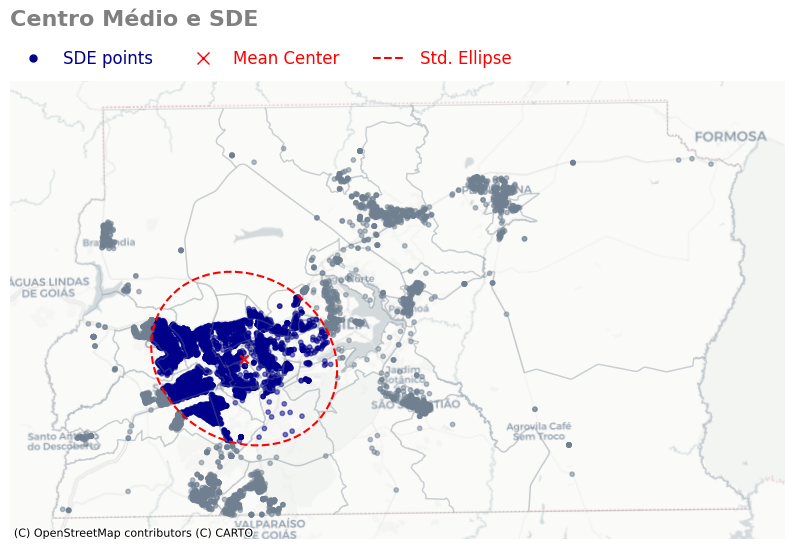

In [18]:
# Configurar figura e eixo
fig, ax = plt.subplots(1, figsize=(10, 8))

# fig.subplots_adjust(right=0.8)

# Lista de cores
clrs = ['darkblue', 'red', 'red']

# Limites das RA
d['regioes_administrativas'].boundary.plot(
    ax=ax,
    linewidth=1,
    alpha=0.2,
    color='slategrey'
)

# Pontos (empresas)
sde_points.plot(
    ax=ax,
    color=sde_points['colors'],
    alpha=0.5,
    markersize=10,
)

# Mean Center
ax.scatter(
    *mean_center,
    color='red',
    marker='x'
)

# SDE
ax.plot(
    ellr.exterior.coords.xy[0],
    ellr.exterior.coords.xy[1],
    color='red',
    linestyle='--'
)

# Title
ax.set_title(
    'Centro Médio e SDE',
    loc='left',
    pad=40,
    fontname='Arial',
    fontsize=16,
    color='grey',
    weight='bold')

# Adicionar mapa base
ctx.add_basemap(
    ax,
    crs=d['final_ras'].crs.to_string(),
    source=ctx.providers.CartoDB.Positron)

# Legendas
custom_points = [
    Line2D([0], [0], marker='o', linestyle='none', markersize=5, color=clrs[0]),
    Line2D([0], [0], marker='x', linestyle='none', markersize=8, color=clrs[1]),
    Line2D([0], [0], linestyle='--', color=clrs[2]),
]

ax.legend(
    custom_points,
    ['SDE points', 'Mean Center', 'Std. Ellipse'],
    ncol=3,
    loc='center left',
    bbox_to_anchor=[0, 1.05],
    borderaxespad=0,
    fontsize=12,
    frameon=False,
    labelcolor=clrs
)

# Remover eixos
ax.set_axis_off()

# Mostrar
plt.show()

In [19]:
# Medidas com SDE
print(
    f'Total de pontos na SDE: {round(points.sum(), 2)}',
    f'Área da SDE: {round(ellr.area/1000000, 2)}',
    f'Porcentagem de pontos na SDE: {round(100 * points.sum() / len(points), 2)}',
    f'Área da SDE / Área total (%): {round(100 * ellr.area / sum(d["final_ras"].area), 2)}',
    sep='\n'
)

Total de pontos na SDE: 5162
Área da SDE: 555.34
Porcentagem de pontos na SDE: 61.99
Área da SDE / Área total (%): 9.63


### 2.3.3 Regiões dos pontos da SDE

In [20]:
r = sde_points[(sde_points['sde_point']==1)]['ra_nome'].unique()

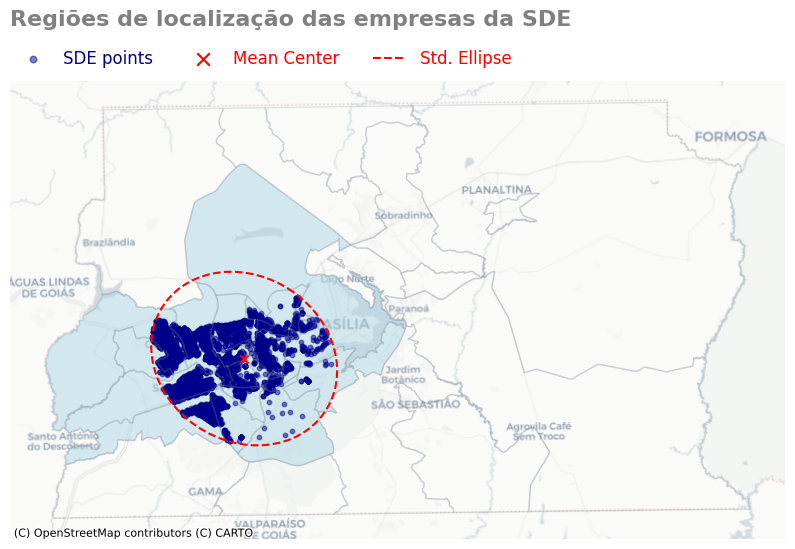

In [21]:
# Configurar figura e eixo
fig, ax = plt.subplots(1, figsize=(10, 8))

# fig.subplots_adjust(right=0.8)

# Lista de cores
clrs = ['darkblue', 'red', 'red']

# Limites das RA
d['regioes_administrativas'].boundary.plot(
    ax=ax,
    linewidth=1,
    alpha=0.2,
    color='slategrey'
)

# Regiões SDE
d['final_ras'][d['final_ras']['ra_nome'].isin(r)].copy().plot(
    ax=ax,
    alpha=0.5,
    color='lightblue'
)

# SDE points
sde_points[(sde_points['sde_point']==1)].plot(
    ax=ax,
    color='darkblue',
    alpha=0.5,
    markersize=10,
    legend=True,
    label='SDE points'
)

# Mean Center
ax.scatter(
    *mean_center,
    color='red',
    marker='x',
    label='Mean Center'
)

# SDE
ax.plot(
    ellr.exterior.coords.xy[0],
    ellr.exterior.coords.xy[1],
    color='red',
    linestyle='--',
    label='Std. Ellipse'
)

# Title
ax.set_title(
    'Regiões de localização das empresas da SDE',
    loc='left',
    pad=40,
    fontname='Arial',
    fontsize=16,
    color='grey',
    weight='bold')

# Adicionar mapa base
ctx.add_basemap(
    ax,
    crs=d['final_ras'].crs.to_string(),
    source=ctx.providers.CartoDB.Positron)

ax.legend(
    ncol=3,
    loc='center left',
    bbox_to_anchor=[0, 1.05],
    borderaxespad=0,
    markerscale=1.5,
    fontsize=12,
    frameon=False,
    labelcolor=clrs
)
# Remover eixos
ax.set_axis_off()

# Mostrar
plt.show()

In [22]:
# Regiões da SDE
sde_r = sde_points.groupby(['ra_cira', 'ra_nome'], as_index=False)['sde_point'].sum().sort_values(by='sde_point', ascending=False)

In [23]:
# Cinco regiões com mais sde_points
sde_r.head(5)

ra_cira           ra_nome  sde_point
8         9         CEILÂNDIA       1105
2         3        TAGUATINGA        854
11       12         SAMAMBAIA        731
14       15  RECANTO DAS EMAS        393
29       30     VICENTE PIRES        337

## 2.4 Distribuição espacial das instalações logísticas em diferentes RA

### 2.4.1 Densidade de empresas (empresas por km2)

In [24]:
d['final_ras'].columns

Index(['ra_cira', 'ra_nome', 'ra_codigo', 'ra_path', 'st_area_sh',
       'st_length_', 's_km_length', 'f_km_length', 'total_h_length', 'cnpj',
       'ra_area_km2', 'companies_km2', 'highway_km2', 'geometry'],
      dtype='object')

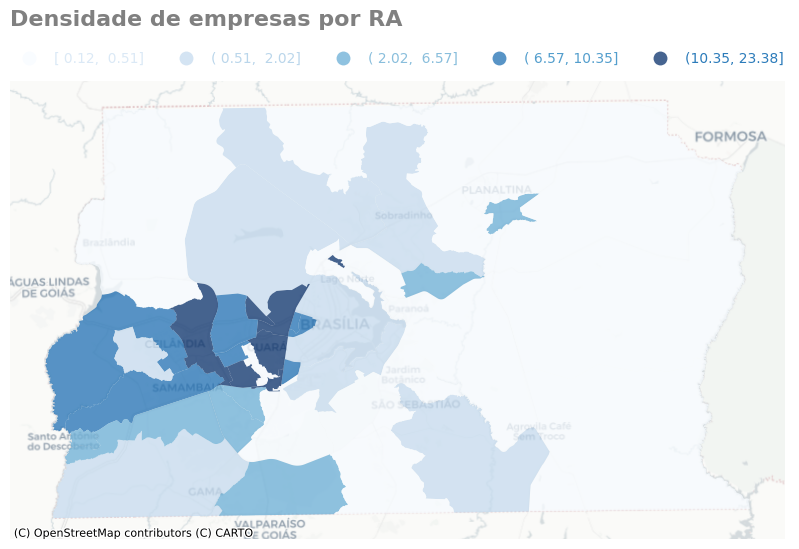

In [25]:
# Empresas/km2

fig, ax = plt.subplots(1, figsize=(10, 8))

d['final_ras'].plot(
    ax=ax,
    column='companies_km2',
    scheme='quantiles',
    cmap='Blues',
    alpha=0.75,
    legend=True,
    legend_kwds={
        'ncol':5,
        'loc':'center left',
        'bbox_to_anchor':[0, 1.05],
        'borderaxespad':0,
        'fontsize':10,
        'frameon':False,
        'labelcolor':list(color_palette('Blues').as_hex()[:5]),
        'interval':True})

ctx.add_basemap(
    ax,
    crs=d['final_ras'].crs.to_string(),
    source=ctx.providers.CartoDB.Positron
)

# Title
ax.set_title(
    'Densidade de empresas por RA',
    loc='left',
    pad=40,
    fontname='Arial',
    fontsize=16,
    color='grey',
    weight='bold')

ax.set_axis_off()

plt.show()

### 2.4.2 Spatial Lags

O **Spatial Lag (Lag Espacial)** é soma dos valores de um atributo nas unidades vizinhas, ou seja, indica se uma unidade geográfica está cercada por outras com valores baixos ou altos (Anselin; Rey, 2014). É dado por:  

$$ L\left(z_i\right)=\sum_{j} w_{ij}z_j $$
onde:
$$ z_i=\frac{x_i-\overline{x}}{\sigma_x} $$


In [26]:
y = d['final_ras']['companies_km2'] # variável/atributo
w = Queen.from_dataframe(d['final_ras']) # Queen Weights (Pesos)
w.transform = 'r' #row standardatization

<ipython-input-26-9da03ff24f43>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(d['final_ras']) # Queen Weights (Pesos)


In [27]:
# Y spatial lag
np.random.seed(12345)
ylag = lag_spatial(w, y)

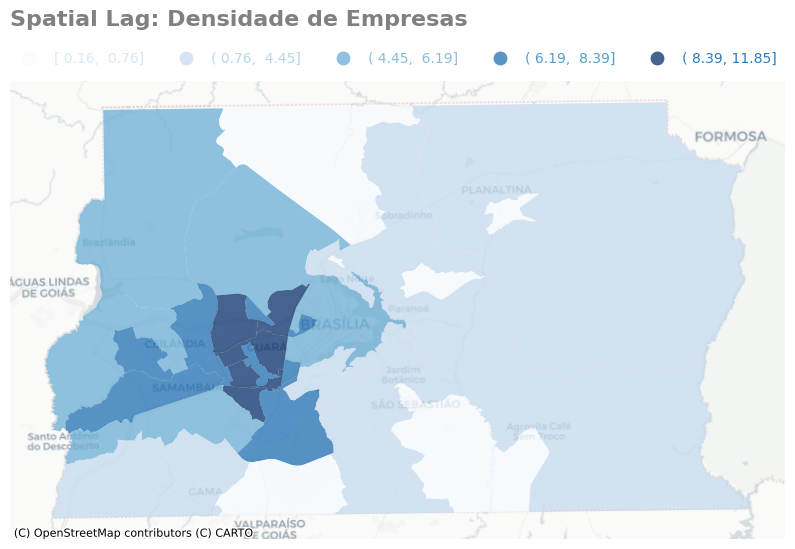

In [28]:
# Empresas/km2

fig, ax = plt.subplots(1, figsize=(10, 8))

d['final_ras'].copy().assign(cl=ylag).plot(
    ax=ax,
    column='cl',
    scheme='quantiles',
    cmap='Blues',
    alpha=0.75,
    legend=True,
    legend_kwds={
        'ncol':5,
        'loc':'center left',
        'bbox_to_anchor':[0, 1.05],
        'borderaxespad':0,
        'fontsize':10,
        'frameon':False,
        'labelcolor':list(color_palette('Blues').as_hex()[:5]),
        'interval':True
    }
)

ctx.add_basemap(
    ax,
    crs=d['final_ras'].crs.to_string(),
    source=ctx.providers.CartoDB.Positron
)

# Title
ax.set_title(
    'Spatial Lag: Densidade de Empresas',
    loc='left',
    pad=40,
    fontname='Arial',
    fontsize=16,
    color='grey',
    weight='bold'
)

ax.set_axis_off()

plt.show()

### 2.4.3 Autocorrelação espacial: Moran's I global univariado

O **Moran’s I global univariado** é um índice que nos ajuda a entender como os valores de uma única variável estão geograficamente distribuídos. Ele varia entre -1 e +1, onde um índice mais próximo de +1 indica que valores semelhantes tendem a estar próximos uns dos outros e valores diferentes tendem a estar distantes uns dos outros.

Sejam $x_i$ e $x_j$ os valores de uma variável **X** em duas unidades geográficas **i** e **j**. Além disso sejam $\bar{x}$ a média da variável **X** e $w_{ij}$ um peso que assume valor 1 ou 0, utilizado para indicar se **i** e **j** são ou não vizinhos. Desse modo, o Moran’s I global para **n** unidades geográficas é dado por:

$$ I=\frac{n\sum_{i}\sum_{j}{w_{ij}\left(x_i-\overline{x}\right)\left(x_j-\overline{x}\right)}}{\sum_{i}\sum_{j}{w_{ij}\sum_{i}\left(x_i-\overline{x}\right)^2}} $$



In [29]:
# Moran's I
np.random.seed(2024)
mi = Moran(y, w)
round(mi.I, 2)

0.33

In [30]:
# Permutações
mi.permutations

999

/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


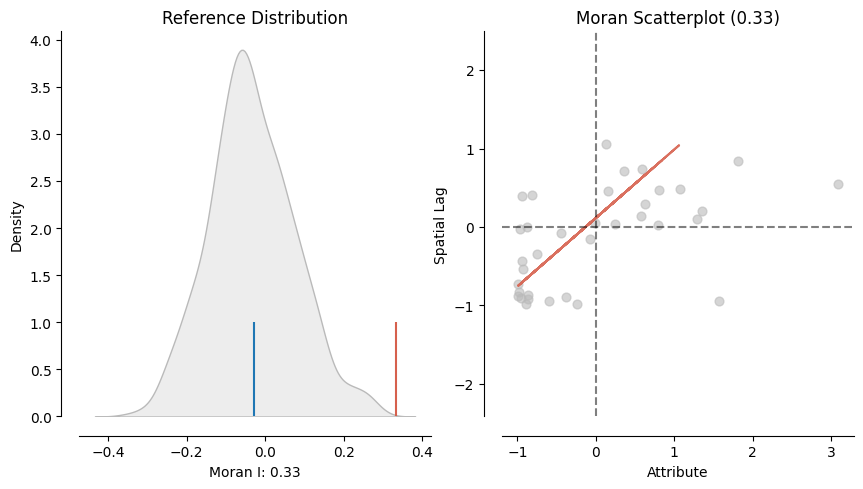

In [31]:
# Moran Scatterplot
plot_moran(
    mi,
    zstandard=True,
    figsize=(10, 5))
plt.show()

In [32]:
# p-valor
mi.p_sim

0.001

### 2.4.4 Autocorrelação espacial: Moran's I local univariado

O **Moran’s I local univariado** é indicador local de associação espacial. Esse índice é calculado para cada unidade geográfica individualmente e os resultados, uma vez agrupados, ajudam-nos a identificar a presença de clusters ou aglomerações de objetos espaciais com atributos de valores altos ou baixos (Anselin, 1995; Smith; Goodchild; Longley, 2021). É dado pela seguinte expressão:

$$ I_i=z_i\sum_{j} w_{ij}z_j $$

Os indicadores locais classificam uma unidade geográfica de análise em quatro categorias: **HH (*High-High*)**, **LL (*Low-Low*)**, **HL (*High-Low*)** e **LH (*Low-High*)**. Uma unidade HH tem um atributo com valor alto e tem vizinhos com atributos altos, enquanto uma unidade LL tem valor baixo e é cercada por valores baixos. Essa classificação auxilia na identificação de clusters espaciais e outliers locais.

In [33]:
# Calcular Local Moran's I
np.random.seed(2024)
moran_loc = Moran_Local(y, w)

In [34]:
# Identificar clusters
# Verificar significância
sig = moran_loc.p_sim < 0.05

# Quadrantes 1, 2, 3, 4 (Moran Scatterplot)
spots = ['n.sig.', 'HH', 'LH', 'LL', 'HL']

# Criar lista com o quadrante para cada RA
l = np.array([0 for i in range(0, len(sig))])
for i in range(1, len(spots[1:])):
    x = sig * moran_loc.q==i
    l = l + np.array(x*(i))
labels = [spots[i] for i in l]

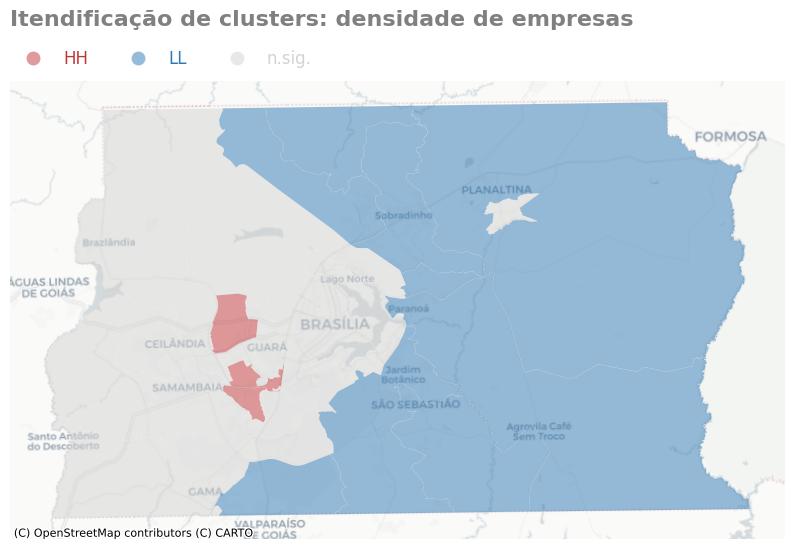

In [35]:
# Cores utilizadas
clrs = ['#c13639', '#2f79b5', 'lightgrey']
hmap = colors.ListedColormap(clrs)

# Figura
fig, ax = plt.subplots(1, figsize=(10, 8))

# Regiões
d['final_ras'].copy().assign(cl=labels).plot(
    column='cl',
    categorical=True,
    k=3,
    cmap=hmap,
    ax=ax,
    linewidth=0.1,
    alpha=0.5,
    edgecolor='white',
    legend=True,
    legend_kwds={
        'ncol':3,
        'loc':'center left',
        'bbox_to_anchor':[0, 1.05],
        'borderaxespad':0,
        'fontsize':12,
        'frameon':False,
        'labelcolor':clrs})

# Title
ax.set_title(
    'Itendificação de clusters: densidade de empresas',
    loc='left',
    pad=40,
    fontname='Arial',
    fontsize=16,
    color='grey',
    weight='bold'
)

ctx.add_basemap(
    ax,
    crs=d['final_ras'].crs.to_string(),
    source=ctx.providers.CartoDB.Positron
)

ax.set_axis_off()

plt.show()

In [36]:
# Regiões HH
hs = [i[0] for i in enumerate(labels) if i[1]=='HH']
d['final_ras'].copy().iloc[hs, [1, 2]]

ra_nome  ra_codigo
8         RIACHO FUNDO    RA-XVII
20  NÚCLEO BANDEIRANTE    RA-VIII
28       VICENTE PIRES     RA-XXX
33          ARNIQUEIRA  RA-XXXIII

In [37]:
# Cluster LL
hs = [i[0] for i in enumerate(labels) if i[1]=='LL']
d['final_ras'].copy().iloc[hs, [1, 2]]

ra_nome  ra_codigo
3        SOBRADINHO       RA-V
12          PARANOÁ     RA-VII
13      SANTA MARIA    RA-XIII
14    SÃO SEBASTIÃO     RA-XIV
17  JARDIM BOTÂNICO   RA-XXVII
19       PLANALTINA      RA-VI
29           FERCAL    RA-XXXI
31    SOBRADINHO II    RA-XXVI
32           ITAPOÃ  RA-XXVIII

## 2.5 Disponibilidade de infraestrutura de transporte no Distrito Federal


### 2.5.1 Rodovias

In [38]:
list(color_palette('RdBu').as_hex())

['#c13639', '#f09c7b', '#fbe3d4', '#dbeaf2', '#87beda', '#2f79b5']

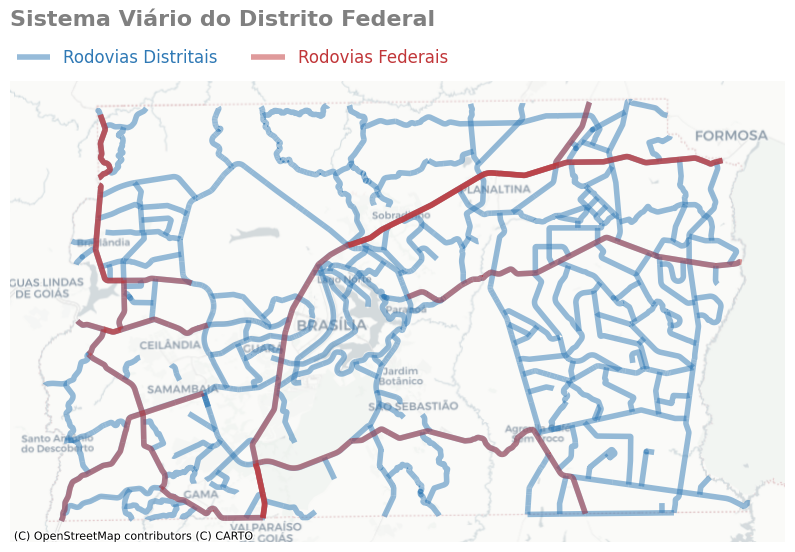

In [39]:
clrs = ['#2f79b5', '#c13639']
rs = ['df_highways_ras', 'df_federal_highways_ras']
ls = ['Rodovias Distritais', 'Rodovias Federais']

fig, ax = plt.subplots(1, figsize=(10, 8))

for i in (0, 1):
    d[rs[i]].plot(
        ax=ax,
        linewidth=4,
        alpha=0.5,
        legend=True,
        color=clrs[i],
        label=ls[i]
    )

ctx.add_basemap(
    ax,
    crs=d['final_ras'].crs.to_string(),
    source=ctx.providers.CartoDB.Positron
)

ax.set_title(
    'Sistema Viário do Distrito Federal',
    loc='left',
    pad=40,
    fontname='Arial',
    fontsize=16,
    color='grey',
    weight='bold'
)

ax.legend(
    ncol=2,
    loc='center left',
    bbox_to_anchor=[0, 1.05],
    borderaxespad=0,
    fontsize=12,
    frameon=False,
    labelcolor=clrs,
)

ax.set_axis_off()
plt.show()

In [40]:
d['final_ras'].columns

Index(['ra_cira', 'ra_nome', 'ra_codigo', 'ra_path', 'st_area_sh',
       'st_length_', 's_km_length', 'f_km_length', 'total_h_length', 'cnpj',
       'ra_area_km2', 'companies_km2', 'highway_km2', 'geometry'],
      dtype='object')

In [41]:
# 5 regiões com maior extensão de vias
d['final_ras'][['ra_nome', 's_km_length', 'f_km_length', 'total_h_length']].sort_values(by='total_h_length', ascending=False).head(5)

ra_nome  s_km_length  f_km_length  total_h_length
19  PLANALTINA   628.541930   164.224850      792.766781
12     PARANOÁ   270.473643    12.672047      283.145690
2   BRAZLÂNDIA   178.283581    68.998746      247.282327
1         GAMA   111.089369    34.380280      145.469649
3   SOBRADINHO    63.820064    38.065878      101.885943

### 2.5.1 Densidade de rede viária (km por km2)

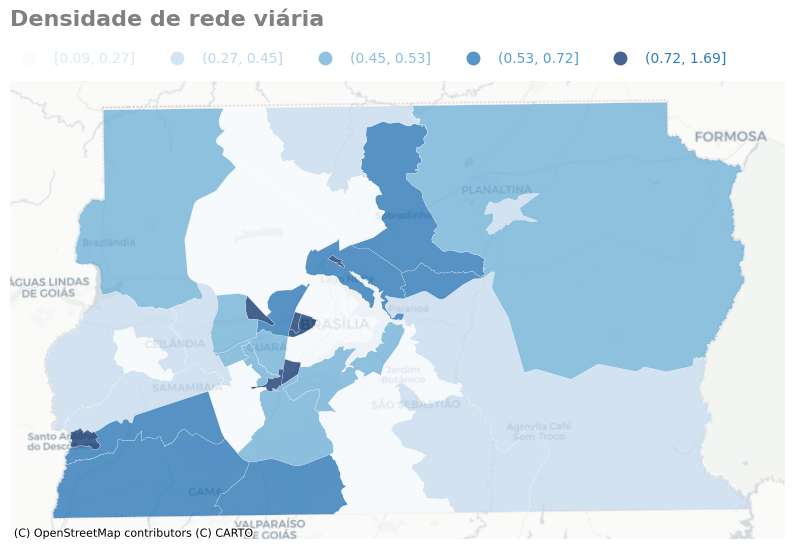

In [42]:
# Densidade de rede viária:
# Rede viária (km) / área (km2)

fig, ax = plt.subplots(1, figsize=(10, 8))

d['final_ras'].plot(
    ax=ax,
    column='highway_km2',
    scheme='quantiles',
    cmap='Blues',
    alpha=0.75,
    linewidth=0.2,
    legend=True,
    edgecolor='white',
    legend_kwds={
        'ncol':5,
        'loc':'center left',
        'bbox_to_anchor':[0, 1.05],
        'borderaxespad':0,
        'fontsize':10,
        'frameon':False,
        'labelcolor':list(color_palette('Blues').as_hex()[:5]),
        'interval':True})

ctx.add_basemap(
    ax,
    crs=d['final_ras'].crs.to_string(),
    source=ctx.providers.CartoDB.Positron
)

# Title
ax.set_title(
    'Densidade de rede viária',
    loc='left',
    pad=40,
    fontname='Arial',
    fontsize=16,
    color='grey',
    weight='bold')

ax.set_axis_off()

plt.show()

In [43]:
d['final_ras'].columns

Index(['ra_cira', 'ra_nome', 'ra_codigo', 'ra_path', 'st_area_sh',
       'st_length_', 's_km_length', 'f_km_length', 'total_h_length', 'cnpj',
       'ra_area_km2', 'companies_km2', 'highway_km2', 'geometry'],
      dtype='object')

In [44]:
# 5 regiões com maior densidade de rede viária
d['final_ras'][['ra_nome', 'total_h_length', 'ra_area_km2', 'highway_km2']].sort_values(by='highway_km2', ascending=False).head(5)

ra_nome  total_h_length  ra_area_km2  highway_km2
25              VARJÃO        2.756367     1.629437     1.691607
6             CRUZEIRO        5.283955     3.191164     1.655808
20  NÚCLEO BANDEIRANTE        7.110948     5.046810     1.408998
9       CANDANGOLÂNDIA        8.127706     6.601864     1.231123
26                SCIA        7.761380     7.386587     1.050740

## 2.6 Relação entre a localização das instalações e infraestrutura de transporte

### 2.6.1 Proximidade das empresas em relação às rodovias

A técnica de **buffering** produz áreas (*Buffers*) ao redor de objetos dentro de uma distância especificada (Smith; Goodchild; Longley; 2021). Assim, é possível determinar quais empresas estão localizadas a uma determinada distância de uma rodovia, o que ajuda a entender a influência da proximidade das rodovias em sua localização.

In [45]:
# Criar buffer  de 1km
buffers_gdf = gpd.GeoDataFrame(
    {'geometry':d['df_highways_ras']['geometry'].buffer(1000).values},
    geometry='geometry',
    crs=d['final_ras'].crs.to_string())

In [46]:
# Unir
u = buffers_gdf['geometry'].unary_union

In [47]:
# GeoDataFrame Buffers (union)
gdf = gpd.GeoDataFrame(
    {'id':[1, 2], 'geometry':u},
    crs=d['final_ras'].crs.to_string(),
    geometry='geometry')

In [48]:
# Pontos dentro dos buffers
points = d['companies_ol_gdf'].copy()['geometry'].apply(lambda p: p.within(u))

In [49]:
# Total de pontos nos buffers
sum(points)

5050

In [50]:
buffers_points = d['companies_ol_gdf'].copy()[['ra_cira', 'ra_nome', 'geometry']]

buffers_points['buffer_point'] = points

In [51]:
buffers_points.head()

ra_cira     ra_nome                        geometry  buffer_point
0        6  PLANALTINA  POINT (226534.386 8275700.566)          True
1        6  PLANALTINA  POINT (226534.386 8275700.566)          True
2        6  PLANALTINA  POINT (226534.386 8275700.566)          True
3        6  PLANALTINA  POINT (205168.132 8269101.829)          True
4        6  PLANALTINA  POINT (209510.893 8271613.748)          True

In [52]:
# Mapear cores (para as legendas do próximo mapa)
buffers_points['colors'] = buffers_points['buffer_point'].map({
    True:'#c13639',
    False:'k'})

In [53]:
list(color_palette('RdBu').as_hex())

['#c13639', '#f09c7b', '#fbe3d4', '#dbeaf2', '#87beda', '#2f79b5']

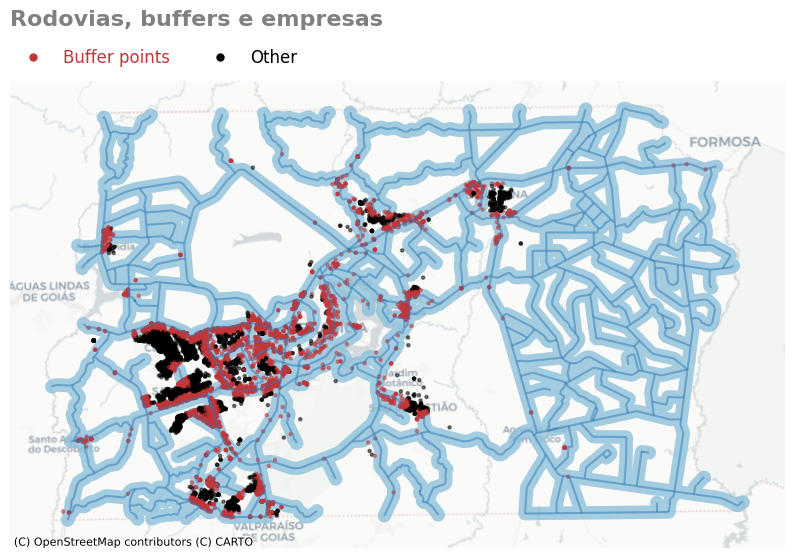

In [54]:
fig, ax = plt.subplots(1, figsize=(10, 8))

clrs = ['#c13639', 'k']
ls = ['Buffer points', 'Other']

# Buffers
gdf.plot(
    ax=ax,
    color='#87beda',
    alpha=0.5
)

# Rodovias
d['df_highways_ras'].plot(
    ax=ax,
    color='#2f79b5',
    alpha=0.5
)

# Pontos nos buffers: a 1 km de uma rodovia
buffers_points.plot(
    ax=ax,
    k=2,
    color=buffers_points['colors'],
    markersize=5,
    alpha=0.5)

# Base
ctx.add_basemap(
    ax,
    crs=d['final_ras'].crs.to_string(),
    source=ctx.providers.CartoDB.Positron
)

# Title
ax.set_title(
    'Rodovias, buffers e empresas',
    loc='left',
    pad=40,
    fontname='Arial',
    fontsize=16,
    color='grey',
    weight='bold')

# Legendas
custom_points = [Line2D([0], [0], marker='o', linestyle='none', markersize=5, color=color) for color in clrs]
ax.legend(
    custom_points,
    ls,
    ncol=2,
    loc='center left',
    bbox_to_anchor=[0, 1.05],
    borderaxespad=0,
    fontsize=12,
    frameon=False,
    labelcolor=clrs
)

ax.set_axis_off()

plt.show()

### 2.6.2 Correlação espacial: Moran's I global bivariado

O **Moran’s I global bivariado** calcula a autocorrelação espacial conjunta entre duas variáveis **X** e **Y**. Sua interpretação é semelhante à do Moran’s I global univariado, indicando se os valores altos ou baixos das duas variáveis estão próximos ou distantes uns dos outros (Anselin; Syabri; Smirnov, 2002). É dado pela seguinte expressão:

$$ I_B=\frac{\sum_{i}\sum_{j} w_{ij}z_1^iz_2^j}{\sum_{i}\left(z_1^i\right)^2} $$

onde $z_1$ e $z_2$ representam, respectivamente, as variáveis **X** e **Y** padronizadas.


In [55]:
x = d['final_ras']['highway_km2'] #variável/atributo
np.random.seed(2024)
moran_bv = Moran_BV(x, y, w) # Bivariate Moran's I
moran_loc_bv = Moran_Local_BV(x, y, w) # Bivariave Local Moran's I

/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:628: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran_bv.sim, shade=shade, color=color, ax=ax, **kwargs)


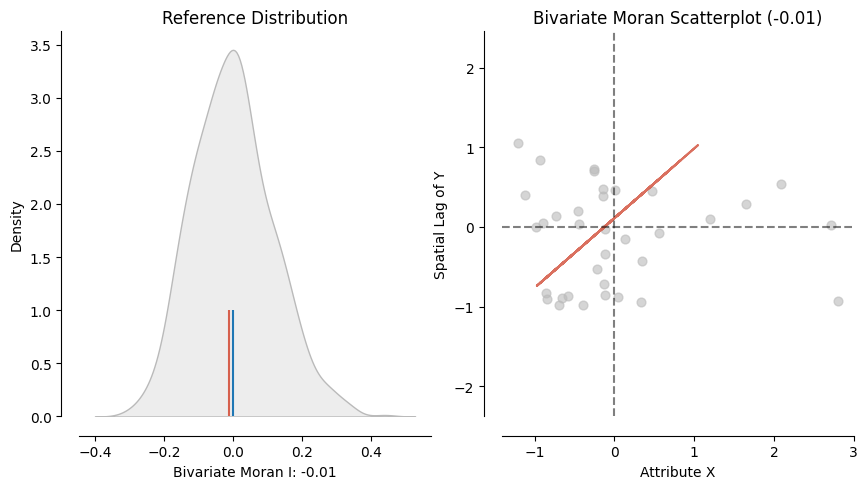

In [56]:
# Moran Scatterplot
plot_moran_bv(
    moran_bv,
    figsize=(10, 5))
plt.show()

In [57]:
# Moran's I Bivariado: índice global
round(moran_bv.I, 2)

-0.01

In [58]:
# p-Valor
moran_bv.p_sim

0.473

### 2.6.3 Correlação espacial: Moran's I local bivariado

O **Moran’s I local bivariado** é semelhante ao Moran’s I local univariado, porém considera duas variáveis **X** e **Y**.

É dado pela seguinte expressão:

$$ I_{z_1z_2}^i=z_1^i\sum_{j} w_{ij}z_2^j $$

In [59]:
# PySAL Scheme: HH=1, LH=2, LL=3, HL=4

In [60]:
# Identificar clusters
# Verificar significância
sig = moran_loc_bv.p_sim < 0.05

# Quadrantes 1, 2, 3, 4 (Moran Scatterplot)
# spots = ['n.sig.', 'hotspot', 'doughnut', 'coldspot', 'diamond']
spots = ['n.sig.', 'HH', 'LH', 'LL', 'HL']

# Criar lista com o quadrante para cada RA
l = np.array([0 for i in range(0, len(sig))])
for i in range(1, len(spots)):
    x = sig * moran_loc_bv.q==i
    l = l + np.array(x*(i))
labels = [spots[i] for i in l]

In [61]:
list(color_palette('RdBu').as_hex())

['#c13639', '#f09c7b', '#fbe3d4', '#dbeaf2', '#87beda', '#2f79b5']

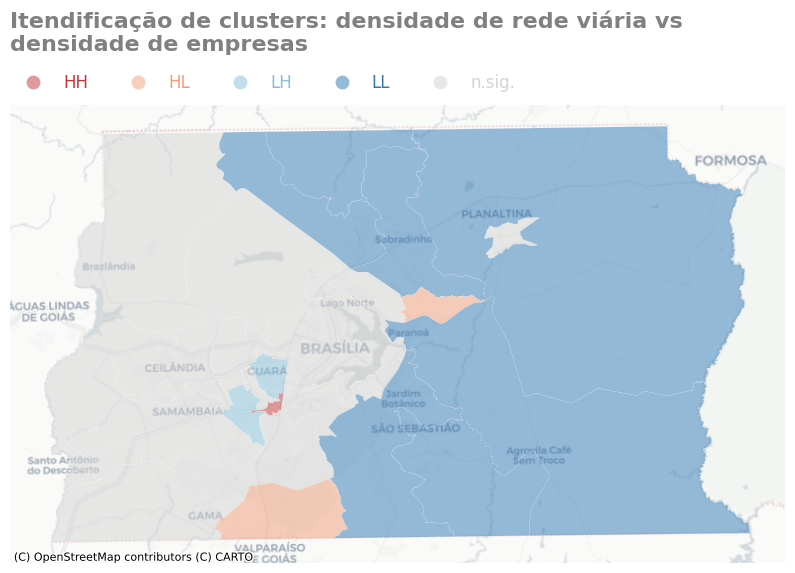

In [62]:
# Cores utilizadas
clrs = ['#c13639', '#f09c7b', '#87beda', '#2f79b5', 'lightgrey']
hmap = colors.ListedColormap(clrs)

# Figura
fig, ax = plt.subplots(1, figsize=(10, 8))

# Regiões
d['final_ras'].copy().assign(cl=labels).plot(
    column='cl',
    categorical=True,
    k=4,
    cmap=hmap,
    ax=ax,
    linewidth=0.2,
    alpha=0.5,
    edgecolor='white',
    legend=True,
    legend_kwds={
        'ncol':5,
        'loc':'center left',
        'bbox_to_anchor':[0, 1.05],
        'borderaxespad':0,
        'fontsize':12,
        'frameon':False,
        'labelcolor':clrs})

# Title
ax.set_title(
    'Itendificação de clusters: densidade de rede viária vs\ndensidade de empresas',
    loc='left',
    pad=40,
    fontname='Arial',
    fontsize=16,
    color='grey',
    weight='bold'
)

ctx.add_basemap(
    ax,
    crs=d['final_ras'].crs.to_string(),
    source=ctx.providers.CartoDB.Positron
)

ax.set_axis_off()

plt.show()

In [63]:
# Cluster LL
hs = [i[0] for i in enumerate(labels) if i[1]=='LL']
d['final_ras'].copy().iloc[hs, [1, 2]]

ra_nome ra_codigo
3        SOBRADINHO      RA-V
12          PARANOÁ    RA-VII
14    SÃO SEBASTIÃO    RA-XIV
17  JARDIM BOTÂNICO  RA-XXVII
19       PLANALTINA     RA-VI
29           FERCAL   RA-XXXI
31    SOBRADINHO II   RA-XXVI

In [64]:
# Cluster HL
hs = [i[0] for i in enumerate(labels) if i[1]=='HL']
d['final_ras'].copy().iloc[hs, [1, 2]]

ra_nome  ra_codigo
13  SANTA MARIA    RA-XIII
32       ITAPOÃ  RA-XXVIII

In [65]:
# Cluster LH
hs = [i[0] for i in enumerate(labels) if i[1]=='LH']
d['final_ras'].copy().iloc[hs, [1, 2]]

ra_nome  ra_codigo
5          GUARÁ       RA-X
8   RIACHO FUNDO    RA-XVII
33    ARNIQUEIRA  RA-XXXIII

In [66]:
hs = [i[0] for i in enumerate(labels) if i[1]=='HH']
d['final_ras'].copy().iloc[hs, [1, 2]]

ra_nome ra_codigo
20  NÚCLEO BANDEIRANTE   RA-VIII

## 2.7 Zoneamento do Distrito Federal

In [67]:
d['companies_ol_gdf'].columns

Index(['cnpj', 'situacao_cadastral', 'cnae_fiscal_principal', 'cep', 'uf',
       'endereco', 'address', 'ra_cira', 'ra_nome', 'ra_codigo', 'ra_path',
       'st_area_sh_1', 'st_length__1', 'macrozona', 'macroarea', 'sigla',
       'emendas', 'area_km', 'area_ha', 'st_area_sh_2', 'st_length__2',
       'geometry'],
      dtype='object')

In [116]:
z = d['companies_ol_gdf'].groupby('macroarea', as_index=False)['cnpj'].count()
z.sort_values(by='cnpj', ascending=False, ignore_index=True, inplace=True)

siglas_zonas = ['ZUC', 'ZUUC II', 'ZUEQ', 'ZUCT', 'ZRUC', 'ZUUC I', 'MPI', 'ZRUD', 'ZCU']

z.insert(
    loc=1,
    column='sigla_zona',
    value=siglas_zonas
)
z

macroarea sigla_zona  cnpj
0                 ZONA URBANA CONSOLIDADA        ZUC  5468
1        ZONA URBANA DE USO CONTROLADO II    ZUUC II  1236
2  ZONA URBANA DE EXPANSÃO E QUALIFICAÇÃO       ZUEQ   695
3         ZONA URBANA DO CONJUNTO TOMBADO       ZUCT   488
4            ZONA RURAL DE USO CONTROLADO       ZRUC   213
5         ZONA URBANA DE USO CONTROLADO I     ZUUC I   189
6          MACROZONA DE PROTEÇÃO INTEGRAL        MPI    17
7         ZONA RURAL DE USO DIVERSIFICADO       ZRUD    16
8                ZONA DE CONTENÇÃO URBANA        ZCU     5

In [119]:
companies_gdf = d['companies_ol_gdf'][['macroarea', 'geometry']].copy()
companies_gdf.head()

macroarea                        geometry
0  ZONA RURAL DE USO CONTROLADO  POINT (226534.386 8275700.566)
1  ZONA RURAL DE USO CONTROLADO  POINT (226534.386 8275700.566)
2  ZONA RURAL DE USO CONTROLADO  POINT (226534.386 8275700.566)
3  ZONA RURAL DE USO CONTROLADO  POINT (205168.132 8269101.829)
4  ZONA RURAL DE USO CONTROLADO  POINT (209510.893 8271613.748)

In [70]:
d['zoneamento_distrito_federal'] = gpd.read_file(
    'data/12_zoneamento_distrito_federal.zip',
    encoding='utf-8')

In [118]:
zoning_gdf = d['zoneamento_distrito_federal'].copy()

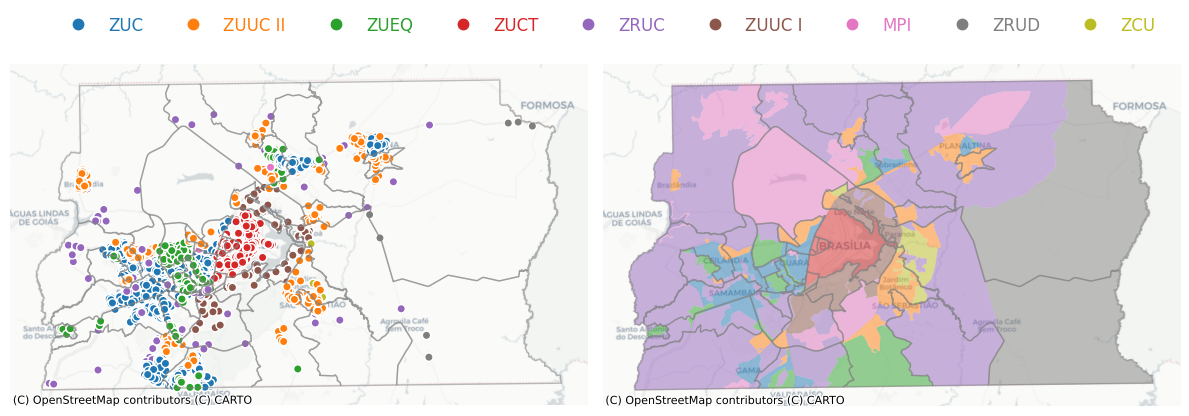

In [120]:
# Nomes das zonas
zoning = z['macroarea'].values
acronyms = z['sigla_zona'].values

# Cores
palette = list(color_palette('tab10').as_hex())
color_dict = {zoning[i]:palette[i] for i in range(0, len(zoning))}

# Coluna cores
companies_gdf.loc[:, 'colors'] = companies_gdf.macroarea.map(color_dict)
zoning_gdf.loc[:, 'colors'] = zoning_gdf.macroarea.map(color_dict)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout='true')

fig.subplots_adjust(bottom=0.2)


d['final_ras'].boundary.plot(ax=ax[0], linewidth=1, alpha=0.5, color='grey')
d['final_ras'].boundary.plot(ax=ax[1], linewidth=1, alpha=0.5, color='grey')

companies_gdf.plot(
    ax=ax[0],
    color=companies_gdf.loc[:, 'colors'],
    edgecolor='white'
)

zoning_gdf.plot(
    ax=ax[1],
    color=zoning_gdf.loc[:, 'colors'],
    alpha=0.5
)

custom_points = [Line2D([0], [0], marker='o', linestyle='none', markersize=5, color=color) for color in color_dict.values()]
for i in range(0, len(ax)):
    # Adicionar mapa base
    ctx.add_basemap(
        ax[i],
        crs=d['final_ras'].crs.to_string(),
        source=ctx.providers.CartoDB.Positron)

    ax[i].set_axis_off()

# Adicionar legenda
fig.legend(
    custom_points,
    acronyms,
    ncol=9,
    loc='center left',
    bbox_to_anchor=[0.05, 0.85],
    borderaxespad=0,
    markerscale=1.5,
    fontsize=12,
    frameon=False,
    labelcolor=color_dict.values(),
    bbox_transform=fig.transFigure
)

plt.show()